### Worker Hash vs Round Robin on Compute Node only (no async) on Mega Data

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import plot_throughput_latency_turnaround, box_plot_throughput_latency_turnaround
import numpy as np
wh_file = "./Throughput Testing/wordcount_no_ndp_no_async_wh_50.csv"
rr_file = "./Throughput Testing/wordcount_no_ndp_no_async_rr_50.csv"

rr_ndp_file = "./Throughput Testing/wordcount_ndp_no_async_rr_50.csv"
wh_ndp_file = "./Throughput Testing/wordcount_ndp_no_async_wh_50.csv"

rr_df = pd.read_csv(rr_file)
wh_df = pd.read_csv(wh_file)

rr_ndp_df = pd.read_csv(rr_ndp_file)
wh_ndp_df = pd.read_csv(wh_ndp_file)

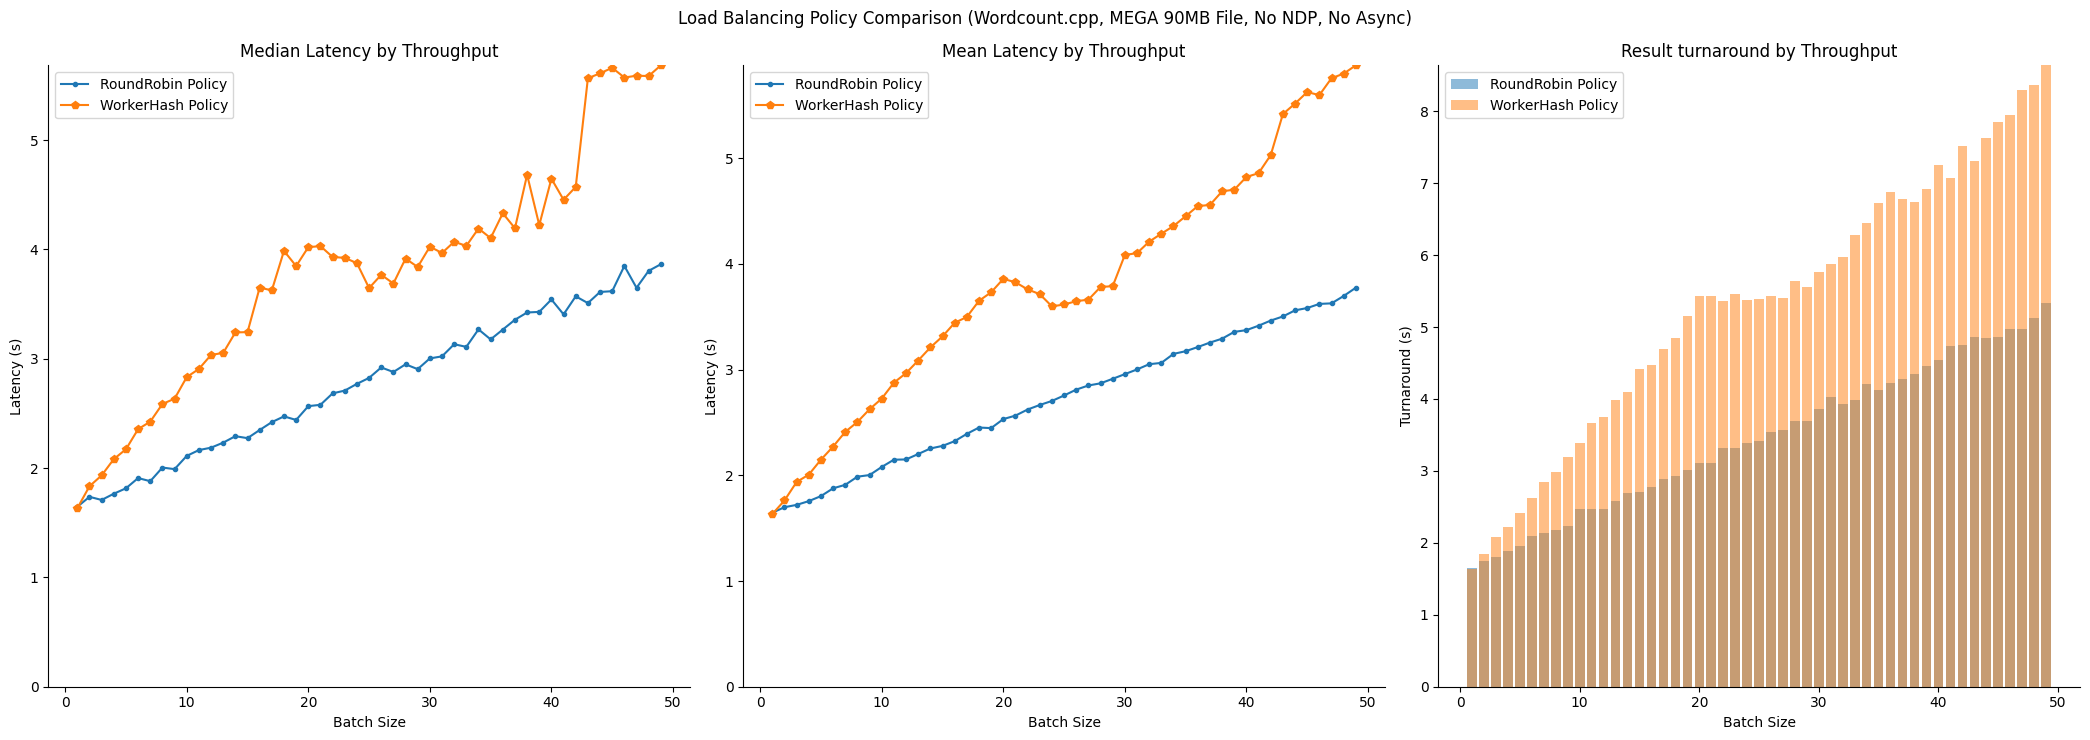

In [20]:
# Generate plots of batch size vs other metrics

import matplotlib.pyplot as plt

# Plot median latency vs batch size
figure_title = 'Load Balancing Policy Comparison (Wordcount.cpp, MEGA 90MB File, No NDP, No Async)'
plot_throughput_latency_turnaround(rr_df, wh_df, 'RoundRobin Policy', 'WorkerHash Policy', figure_title)

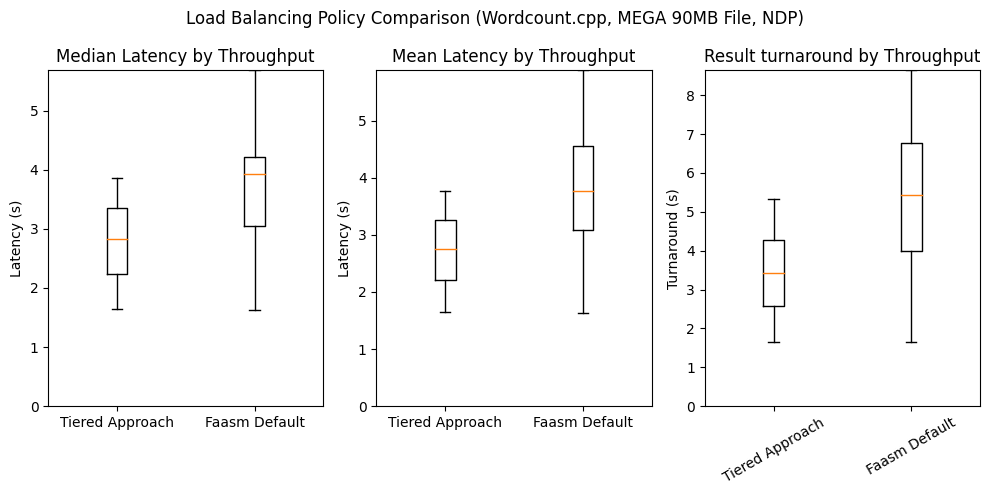

In [21]:
figure_title = 'Load Balancing Policy Comparison (Wordcount.cpp, MEGA 90MB File, NDP)'
box_plot_throughput_latency_turnaround(rr_df, wh_df, 'Tiered Approach', 'Faasm Default', figure_title)

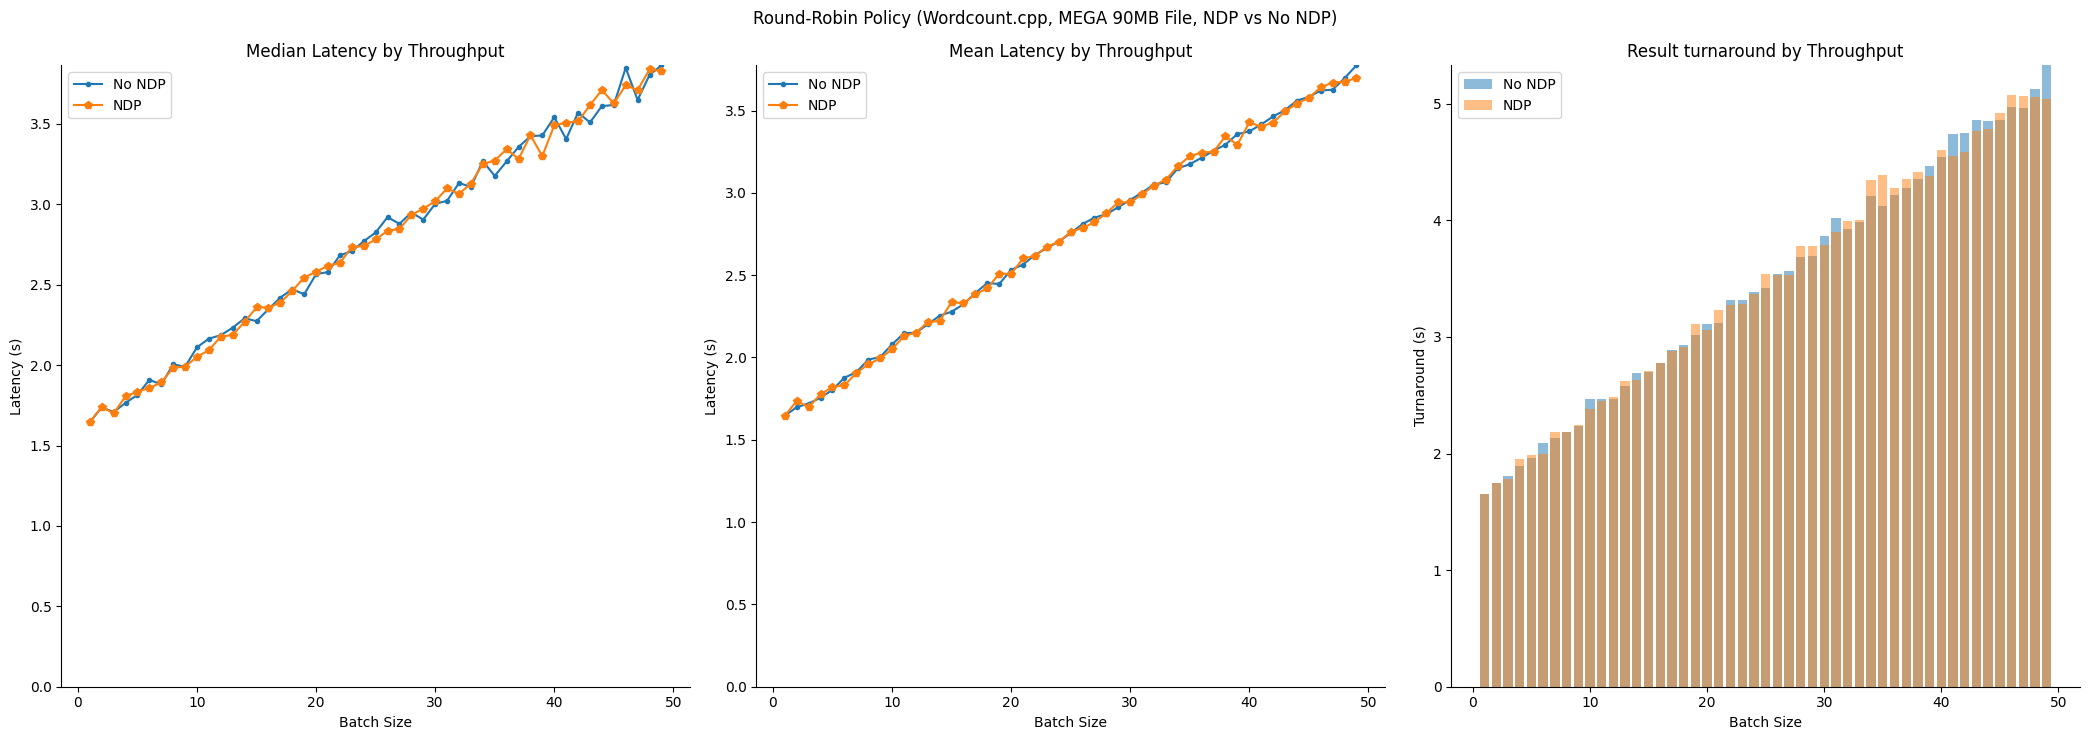

In [22]:
figure_title = 'Round-Robin Policy (Wordcount.cpp, MEGA 90MB File, NDP vs No NDP)'
plot_throughput_latency_turnaround(rr_df, rr_ndp_df, 'No NDP', 'NDP', figure_title)


In [23]:
print("Variance of Median Latency for RoundRobin Policy (No NDP): ", rr_df['Median Latency'].var())
print("Variance of Median Latency for RoundRobin Policy (NDP): ", rr_ndp_df['Median Latency'].var())
print("Correlation of Median Latency for RoundRobin Policy (No NDP): ", rr_df['Median Latency'].corr(rr_df['Batch Size']))
print("Correlation of Median Latency for RoundRobin Policy (NDP): ", rr_ndp_df['Median Latency'].corr(rr_ndp_df['Batch Size']))

Variance of Median Latency for RoundRobin Policy (No NDP):  0.43194471717377514
Variance of Median Latency for RoundRobin Policy (NDP):  0.43804620194140603
Correlation of Median Latency for RoundRobin Policy (No NDP):  0.9969606500532272
Correlation of Median Latency for RoundRobin Policy (NDP):  0.998143195111349


In [24]:
print("Variance of WorkerHash results:")
print("Traditional FaaS (no-ndp): ", wh_df['Median Latency'].var())
print("NDP FaaS: ", wh_ndp_df['Median Latency'].var())

Variance of WorkerHash results:
Traditional FaaS (no-ndp):  1.1408281671615854
NDP FaaS:  1.1929452757239267


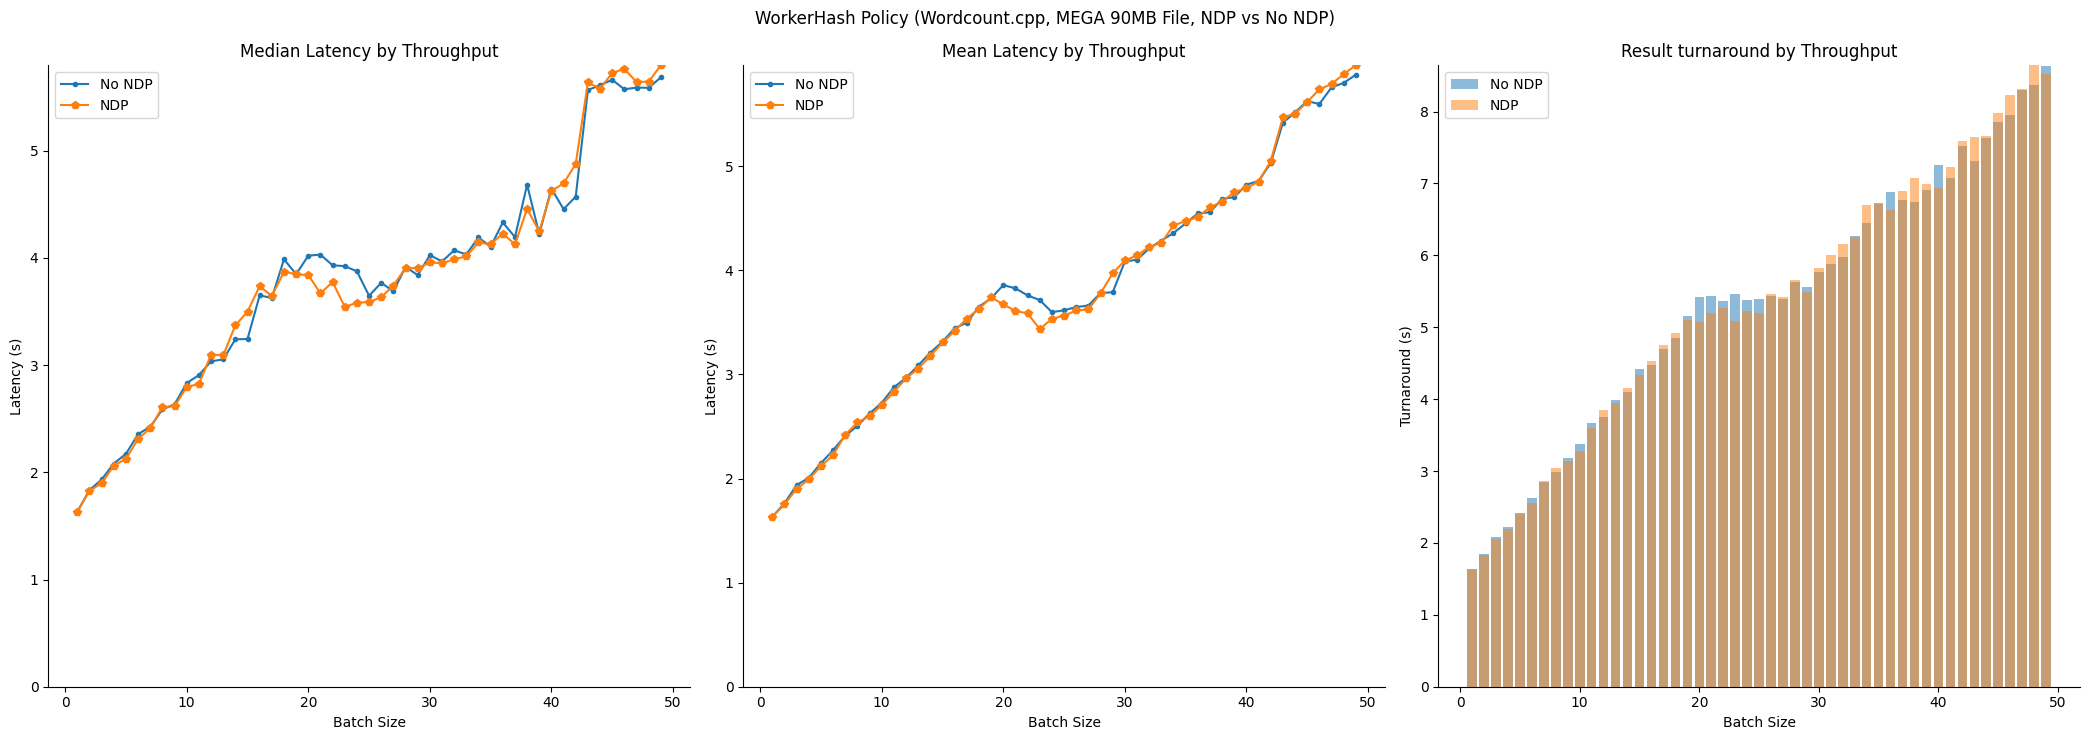

In [25]:
figure_title = 'WorkerHash Policy (Wordcount.cpp, MEGA 90MB File, NDP vs No NDP)'
plot_throughput_latency_turnaround(wh_df, wh_ndp_df, 'No NDP', 'NDP', figure_title)


### Offloading vs Traditional Method

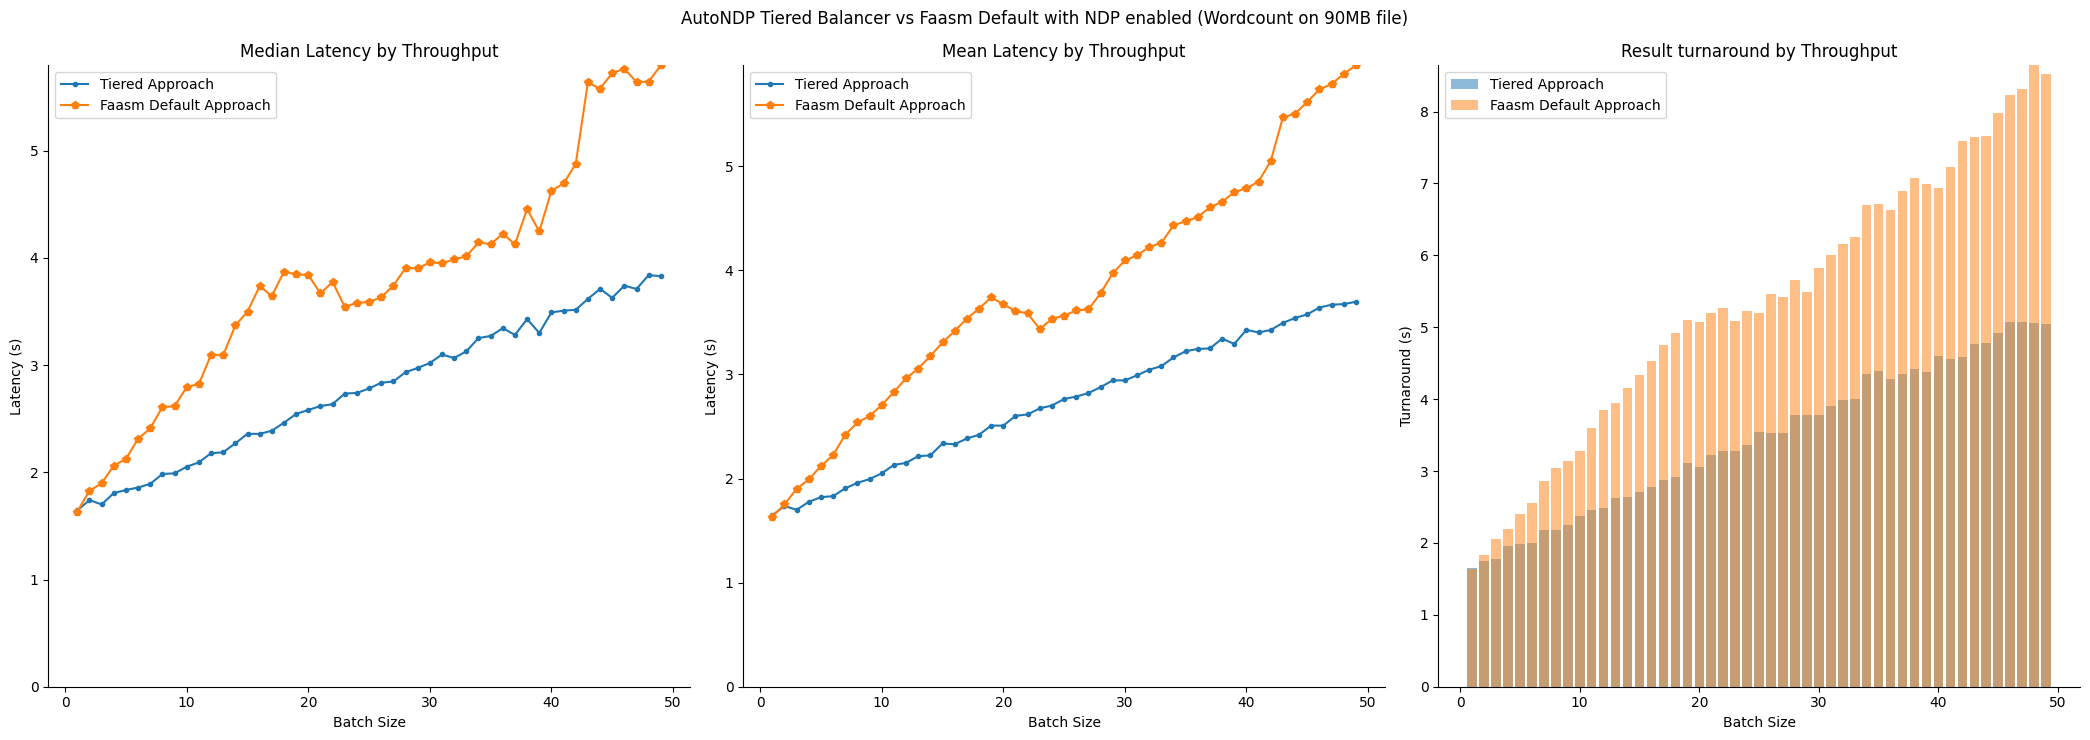

In [26]:
figure_title = 'AutoNDP Tiered Balancer vs Faasm Default with NDP enabled (Wordcount on 90MB file)'
plot_throughput_latency_turnaround(rr_ndp_df, wh_ndp_df, 'Tiered Approach', 'Faasm Default Approach', figure_title)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# rr_ndp Policy
X = rr_ndp_df['Batch Size'].values.reshape(-1, 1)
y = rr_ndp_df['Median Latency'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rr_ndp_regressor = LinearRegression()
rr_ndp_regressor.fit(X_train, y_train)
y_pred = rr_ndp_regressor.predict(X_test)
print('Tiered Approach with NDP enabled (rr_ndp) Policy')
print('Coefficients: ', rr_ndp_regressor.coef_)
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination: ', r2_score(y_test, y_pred))
print('Predicted Median Latency for Batch Size 2500: ', rr_ndp_regressor.predict(np.array([[2500]])))
print('')
X = wh_ndp_df['Batch Size'].values.reshape(-1, 1)
y = wh_ndp_df['Median Latency'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
wh_regressor = LinearRegression()
wh_regressor.fit(X_train, y_train)
y_pred = wh_regressor.predict(X_test)
print('Default Faasm Policy with NDP enabled')
print('Coefficients: ', wh_regressor.coef_)
print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
print('Coefficient of Determination: ', r2_score(y_test, y_pred))
print('Predicted Median Latency for Batch Size 2500: ', wh_regressor.predict(np.array([[2500]])))

speedup = wh_regressor.predict(np.array([[2500]])) / rr_ndp_regressor.predict(np.array([[2500]]))
speedup = np.round(speedup, 3)
print("Predicted improvement in median latency for rr_ndp Policy with batch size 2500 vs rr Policy with batch size 2500: ", speedup)

Tiered Approach with NDP enabled (rr_ndp) Policy
Coefficients:  [[0.04598896]]
Mean Squared Error:  0.001049123405686741
Coefficient of Determination:  0.9969670525191268
Predicted Median Latency for Batch Size 2500:  [[116.59200072]]

Default Faasm Policy with NDP enabled
Coefficients:  [[0.07490386]]
Mean Squared Error:  0.09431872861577319
Coefficient of Determination:  0.8523325517121135
Predicted Median Latency for Batch Size 2500:  [[189.22893963]]
Predicted improvement in median latency for rr_ndp Policy with batch size 2500 vs rr Policy with batch size 2500:  [[1.623]]
